## NLP SPAM DETECTOR

NLP assignment for A.Y. 2024/2025

Spam detection is a classic problem in machine learning problem and in cybersecurity. This project aims to develop a technology that automatically identify spam emails, based only on their textual content and their provenance (i.e., the SMTP sender domain).

Since the dataset dos not include information about the origin of the email, but only its content, this project is focused on analyzing the number of occurrence of the most common words in the emails.

Each sample in the dataset contains:
- The number of occurrences for each word in a fixed vocabulary
- A binary label: 1 for spam, 0 for non-spam


## 1) Importing useful libraries

In [45]:
import nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score

random_seed = 23

## 2) Loading the dataset

In [57]:
file_path = 'data/emails.csv'

try:
    email_df = pd.read_csv(file_path)
    print("Dataset loaded correctly.")
except FileNotFoundError:
    print("File not found in path.")
    exit()

print(f"Shape: {email_df.shape}")
print(f"Columns: {email_df.columns}")
print("\nSample row:")
print(email_df.head(1))

Dataset loaded correctly.
Shape: (5172, 3002)
Columns: Index(['Email No.', 'the', 'to', 'ect', 'and', 'for', 'of', 'a', 'you', 'hou',
       ...
       'connevey', 'jay', 'valued', 'lay', 'infrastructure', 'military',
       'allowing', 'ff', 'dry', 'Prediction'],
      dtype='object', length=3002)

Sample row:
  Email No.  the  to  ect  and  for  of  a  you  hou  ...  connevey  jay  \
0   Email 1    0   0    1    0    0   0  2    0    0  ...         0    0   

   valued  lay  infrastructure  military  allowing  ff  dry  Prediction  
0       0    0               0         0         0   0    0           0  

[1 rows x 3002 columns]


## Class visualization

Since the task is binary classification I want to see the balance between the two labels and plot it.

Prediction
0    3672
1    1500
Name: count, dtype: int64


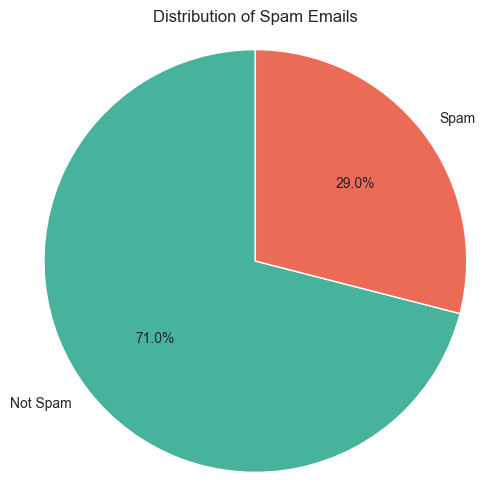

In [58]:
counts = email_df['Prediction'].value_counts()
print(counts)
labels = ['Not Spam', 'Spam']
colors = ['#47B39C', '#EC6B56']  #47B39C

plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Distribution of Spam Emails")
plt.axis('equal')
plt.show()

I can see that the classes are imbalanced, which is normal since spam emails are less than non spam, hopefully.

## 3) Stopwords

Stopwords are high-frequency words that do not add a significant semantic value to a text.
A common step in NLP is to remove these words to reduce noise and dimensionality, allowing the model to focus on more meaningful features that are more representative of a certain class.

To determine the optimal approach for this dataset, I evaluated the models on 2 different features set: one containing all the features, the other with all the English stopwords removed.

In [17]:
try:
    stopwords.words('english')
except LookupError:
    print("Downloading stopwords list from nltk")
    nltk.download('stopwords')

stop_words_set = set(stopwords.words('english'))
print(f"Number of stopwords in nltk list: {len(stop_words_set)}")
print(f"Stop words example:", list(stop_words_set)[:10])


Number of stopwords in nltk list: 198
Stop words example: ["he's", 'her', "they'll", 'doesn', "we'd", "we've", 'than', 'when', 'most', 'over']


In [22]:
# Defining 2 dataset, one with all feature, the other without stopwords

X = email_df.drop(['Email No.', 'Prediction'], axis=1)
y = email_df['Prediction']  # this is the target Label

# Finding stopwords in our dataset
all_words = X.columns.tolist()
stopw_columns = [word for word in all_words if word in stop_words_set]
print(f"Number of stopwords found: {len(stopw_columns)}")

X_no_stopw = X.drop(columns=stopw_columns)

'''First dataset -> all features'''

# train/test split (70/30), with stratified class
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=random_seed
)

'''Second dataset -> no stopwords'''

# same for second dataset
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    X_no_stopw, y, test_size=0.3, stratify=y, random_state=random_seed
)

print("--- ALL FEATURES ---")
print(f"Training set dimension: {X_train.shape}")
print(f"Test set dimension: {X_test.shape}")
print(f"Train and Test labels dimensions: {y_train.shape, y_test.shape}")


print("--- NO STOPWORDS ---")
print(f"Training set dimension: {X_train_ns.shape}")
print(f"Test set dimension: {X_test_ns.shape}")
print(f"Train and Test labels dimensions: {y_train_ns.shape, y_test_ns.shape}")


Number of stopwords found: 134
--- ALL FEATURES ---
Training set dimension: (3620, 3000)
Test set dimension: (1552, 3000)
Train and Test labels dimensions: ((3620,), (1552,))
--- NO STOPWORDS ---
Training set dimension: (3620, 2866)
Test set dimension: (1552, 2866)
Train and Test labels dimensions: ((3620,), (1552,))


## 4) Classification with Naive Bayes

 I am using a MultinomialNB as a first model, because it's designed for discrete features like word counts.
 Feature scaling is not applied since this probabilistic model's performance is not dependent on feature magnitude (unlike GaussianNB).


In [23]:
def evaluate_naive_bayes(X_train, X_test, y_train, y_test, label=''):

    naive_bayes_model = MultinomialNB()
    naive_bayes_model.fit(X_train, y_train)
    y_pred_nb = naive_bayes_model.predict(X_test)

    print(f"\nNaive bayes - {label}")
    print(f"F1-score is: {f1_score(y_test, y_pred_nb)}")
    print(f"Confusion Matrix: {confusion_matrix(y_test, y_pred_nb)}")
    print(f"Classification Report: {classification_report(y_test, y_pred_nb)}")


evaluate_naive_bayes(X_train, X_test, y_train, y_test, label='All features')
evaluate_naive_bayes(X_train_ns, X_test_ns, y_train_ns, y_test_ns, label='No stopwords')

--- Naive Bayes Results (with all features) ---

Naive bayes - All features
F1-score is: 0.9050632911392406
Confusion Matrix: [[1033   69]
 [  21  429]]
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.94      0.96      1102
           1       0.86      0.95      0.91       450

    accuracy                           0.94      1552
   macro avg       0.92      0.95      0.93      1552
weighted avg       0.95      0.94      0.94      1552

--- Naive Bayes Results (without stopwords) ---

Naive bayes - No stopwords
F1-score is: 0.8996832101372756
Confusion Matrix: [[1031   71]
 [  24  426]]
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.94      0.96      1102
           1       0.86      0.95      0.90       450

    accuracy                           0.94      1552
   macro avg       0.92      0.94      0.93      1552
weighted avg       0.94      0.94      0.94      

The model perform slightly better with all features
I obtain the model learns that stop words are not discriminants and give them a low weight in the final decision. They can be seen as noise that MultinomialNB can deal alone.

## 5) Classification with a simple FFNN

Using here a simple MLP with 1 layer and no custom parameters as a second model.
Since NNs benefit from standardization, I will also scale the data.


In [38]:
def evaluate_simple_ffnn(X_train, X_test, y_train, y_test, label=''):

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    simple_mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=50, activation='relu', early_stopping=True, random_state=random_seed)

    simple_mlp.fit(X_train_scaled, y_train)
    y_pred = simple_mlp.predict(X_test_scaled)

    print(f"--- Results with simple FFNN ({label}) ---")
    f1 = f1_score(y_test, y_pred)
    print(f"F1 score on test set is: {f1}")
    print(classification_report(y_test, y_pred, target_names=['Not Spam', 'Spam']))
    print("***Confusion Matrix***")
    print(confusion_matrix(y_test, y_pred))


evaluate_simple_ffnn(X_train, X_test, y_train, y_test, label='All features')
evaluate_simple_ffnn(X_train_ns, X_test_ns, y_train_ns, y_test_ns, label='No stopwords')

--- Results with simple FFNN (All features) ---
F1 score on test set is: 0.9538131041890441
              precision    recall  f1-score   support

    Not Spam       0.99      0.97      0.98      1102
        Spam       0.92      0.99      0.95       450

    accuracy                           0.97      1552
   macro avg       0.96      0.98      0.97      1552
weighted avg       0.97      0.97      0.97      1552

***Confusion Matrix***
[[1065   37]
 [   6  444]]
--- Results with simple FFNN (No stopwords) ---
F1 score on test set is: 0.9545454545454546
              precision    recall  f1-score   support

    Not Spam       0.99      0.97      0.98      1102
        Spam       0.93      0.98      0.95       450

    accuracy                           0.97      1552
   macro avg       0.96      0.98      0.97      1552
weighted avg       0.97      0.97      0.97      1552

***Confusion Matrix***
[[1069   33]
 [   9  441]]


Here I obtained slightly better but not relevant improvement (+0.001) using the dataset without stopwords. I can see that this baseline MLP model performs better than the Naive Bayes, producing better results, in particular it improves the precision of classifying the Spam class.

## 6) Classification with custom MLP
For the last model, I will use an optimized MLP, performing grid search to choose the best architecture & hyperparameters.

Since the dataset is not so big, I decide for at maximum 2 hidden layers.
Adding more layers may cause overfitting.

#### Grid search


In [59]:
def hparams_tuning(X_train, y_train):

    mlp_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(random_state=random_seed, max_iter=100, early_stopping= True, n_iter_no_change=10))
    ])

    neurons_number = []
    for first_layer in range(40, 121, 20):
        for second_layer in range(20, first_layer+1, 20):
            neurons_number.append((first_layer, second_layer))

    hparam_grid = {
        'mlp__hidden_layer_sizes': neurons_number,
        'mlp__activation': ['relu', 'tanh'],
        'mlp__alpha': [0.001, 0.005, 0.01],
    }

    grid_search = GridSearchCV(
        mlp_pipeline,
        hparam_grid,
        cv=3,
        scoring='f1',
        verbose=1,
        n_jobs=-1
    )

    print("Starting GridSearchCV on the hyperparameter grid.")
    starting_time = time.time()
    # Training of the best model found
    grid_search.fit(X_train, y_train)
    ending_time = time.time()
    print(f"Grid Search finished in {ending_time - starting_time:.2f} seconds")
    print(f"Best hparams found: {grid_search.best_params_}")

    return grid_search.best_estimator_


best_model = hparams_tuning(X_train, y_train)

Starting GridSearchCV on the hyperparameter grid.
Fitting 3 folds for each of 120 candidates, totalling 360 fits
Grid Search finished in 451.09 seconds
Best hparams found: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (120, 100)}


#### Evaluation of the best model


--- Results with custom MLP (All features) ---
F1-score (training): 0.9976
F1-score (testing): 0.9648
              precision    recall  f1-score   support

    Not Spam       0.99      0.98      0.99      1102
        Spam       0.95      0.98      0.96       450

    accuracy                           0.98      1552
   macro avg       0.97      0.98      0.98      1552
weighted avg       0.98      0.98      0.98      1552

ROC-AUC score: 0.9977


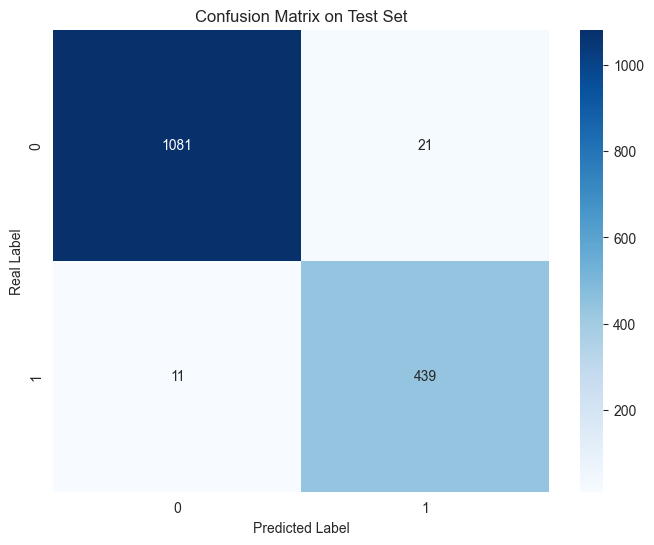

In [48]:
def evaluate_mlp(best_model, X_train, X_test, y_train, y_test, label=''):

    # CHecking for overfitting
    print(f"--- Results with custom MLP ({label}) ---")
    f1_train = f1_score(y_train, best_model.predict(X_train))
    f1_test = f1_score(y_test, best_model.predict(X_test))
    print(f"F1-score (training): {f1_train:.4f}")
    print(f"F1-score (testing): {f1_test:.4f}")

    # Metrics + report
    y_pred = best_model.predict(X_test)
    logits = best_model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, logits)
    print(classification_report(y_test, y_pred, target_names=['Not Spam', 'Spam']))
    print(f"ROC-AUC score: {auc_score:.4f}")

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap= 'Blues')
    plt.title('Confusion Matrix on Test Set')
    plt.ylabel('Real Label')
    plt.xlabel('Predicted Label')
    plt.savefig('conf_matrix.png')
    plt.show()

evaluate_mlp(best_model, X_train, X_test, y_train, y_test, label='All features')

For the final analysis the full feature set was selected since initial tests showed that removing stopwords did not cause a significant performance improvement, making a second computationally expensive hyperparameter search, which is impractical since good results are already achieved.

Performance slightly improved from the baseline model, classifying better the less represented class.

## 7) PCA visualization

PCA is used here for plotting into a more interpretable 2D view the 3000-dimensional feature space. It shows the contrast between the model's predictions and the true label, assessing the classifier's performance.


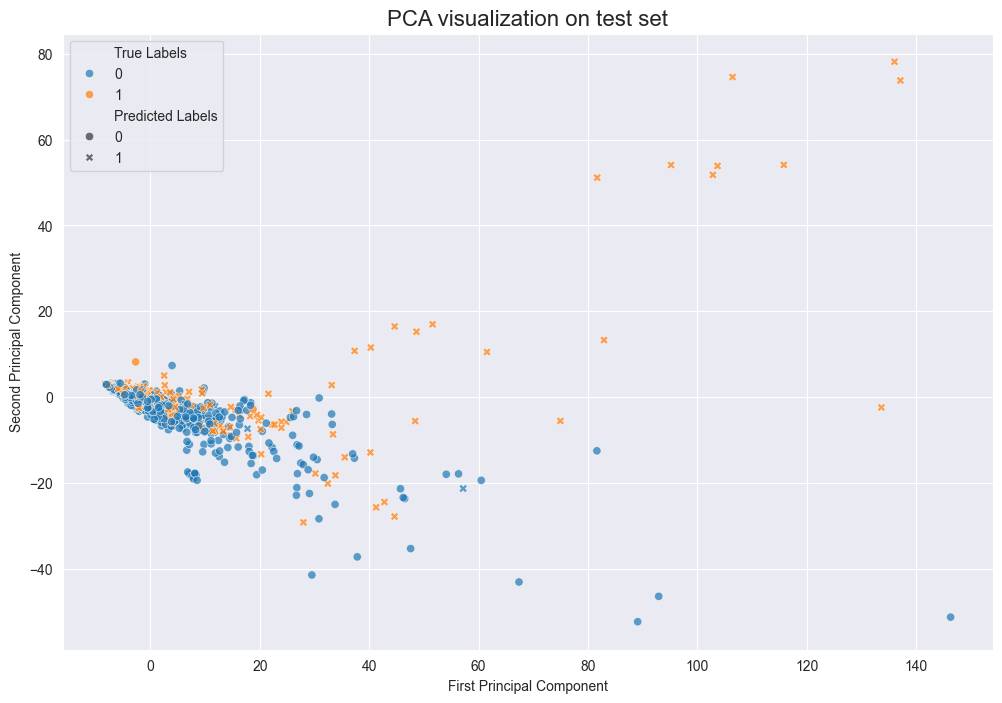

In [61]:
# Using PCA with 2 components for a more compact visualization
pca = PCA(n_components=2)
pca.fit(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

pca_df = pd.DataFrame(
    data=X_test_pca,
    columns=['PC1', 'PC2']
)
# True Labels
pca_df['True Labels'] = y_test.values
# Predicted labels from the mlp
pca_df['Predicted Labels'] = best_model.predict(X_test)

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='True Labels',
    style='Predicted Labels',
    data=pca_df,
    alpha=0.7
)
plt.title('PCA visualization on test set', fontsize=16)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

The x-axis here represents the first principal component, which captures the most variance within the data.

This plot shows that the classifier not only separates the main data cluster effectively but also classify correctly most outliers, the samples that are distant from their class' primary distribution.

## 8) Feature Importance

Finally, using sklearn's `permutation_importance` to see the words that contribute most to classify an email as spam.

In [51]:
from sklearn.inspection import permutation_importance

r = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=random_seed)  # consider using lower n_repeats value to reduce time
importances = pd.Series(r.importances_mean, index=X.columns)
important_words = importances.sort_values(ascending=False).head(20)


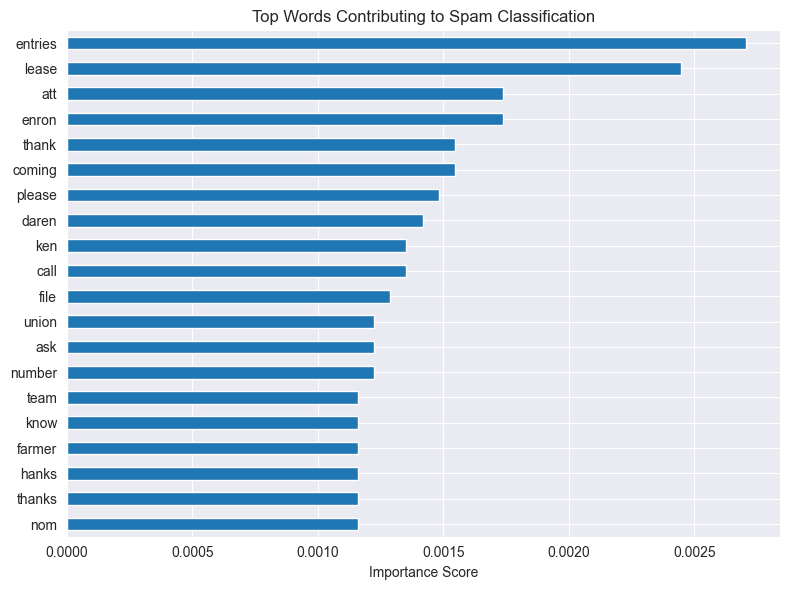

In [53]:
important_words.plot(kind='barh', figsize=(8, 6), title='Top Words Contributing to Spam Classification')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusions

The optimized MLP with 2 hidden layers proved to perform slightly better than the baseline models for this binary classification task, achieving a **F1-score of 96.4%** on test set.

Furthermore, by removing english stopwords from the dataset, no significant performance improvement was achieved, indicating that the models effectively handles common words without pre-processing.